# Sleeplessness in Seattle - an analysis of Seattle crime

In this project, I want to conduct an analysis of Seattle crime data. In particular, we will:
1. preprocess the data,
2. consider the most frequent *type* of crime,
3. consider the most frequent *time* for crime,
4. consider the most frequent *district/zone* for crime,
5. use the k-means clustering algorithm to assess whether or not Seattle should redistrict/rezone.

The all around goal is to inform better decisions about where the police in Seattle should focus their efforts.

In [1]:
# Some important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap    # Plotting geospatial data
%matplotlib inline
import seaborn as sb    # Prettier visualizations
from IPython.display import display     # For nice display in notebook

## Step 1: Preprocessing

Let's make the data look pretty. 

A quick glimpse at the data shows that some records have Latitude or Longitude set to 0.0. This doesn't help us! Let's get rid of those on import.

Also, let's make a column for the date/time of the crime. The current data has a report date, a start date and an end date. In an ideal world, we would like to discover/prevent the crime at it's (supposed) start. Let's use that as the date/time of the crime.

In [2]:
# Read in data, change column names to lowercase, replace 0.0 Lat/Lon with NaN, drop records w/ NaN
seattleDF = (pd.read_csv('seattle_incidents_summer_2014.csv')
             .rename(columns=str.lower)
             .assign(latitude=lambda x: x['latitude'].replace(to_replace=0.0, value=np.NaN),
                     longitude=lambda x: x['longitude'].replace(to_replace=0.0, value=np.NaN),
                     datetime=lambda x: pd.to_datetime(x['occurred date or date range start'], 
                                                      format='%m/%d/%Y %I:%M:%S %p'))
             .dropna(subset=['latitude','longitude'])
            )

# Let's have a peak
seattleDF.head()

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,rms cdw id,general offense number,offense code,offense code extension,offense type,summary offense code,summarized offense description,date reported,occurred date or date range start,occurred date range end,hundred block location,district/sector,zone/beat,census tract 2000,longitude,latitude,location,month,year,datetime
0,483839,2015218538,2202,0,BURGLARY-FORCE-RES,2200,BURGLARY,06/28/2015 10:31:00 AM,06/28/2014 10:31:00 AM,06/28/2015 10:31:00 AM,6XX BLOCK OF NW 74 ST,J,J2,2900.3013,-122.364672,47.682524,"(47.68252427, -122.364671996)",6,2014,2014-06-28 10:31:00
1,481252,2015213067,2610,0,FRAUD-IDENTITY THEFT,2600,FRAUD,06/24/2015 11:09:00 AM,06/01/2014 12:00:00 AM,06/24/2015 11:09:00 AM,23XX BLOCK OF 43 AV E,C,C2,6300.1004,-122.277080,47.639901,"(47.639900761, -122.277080248)",6,2014,2014-06-01 00:00:00
2,481375,2015210301,2316,0,THEFT-MAIL,2300,MAIL THEFT,06/22/2015 09:22:00 AM,08/31/2014 09:00:00 AM,NaN,81XX BLOCK OF 11 AV SW,F,F3,11300.5013,-122.349312,47.529232,"(47.529232299, -122.349312181)",8,2014,2014-08-31 09:00:00
3,481690,2015209327,2599,0,COUNTERFEIT,2500,COUNTERFEIT,06/21/2015 03:52:00 PM,06/20/2014 01:38:00 PM,NaN,6XX BLOCK OF PINE ST,M,M2,8200.1002,-122.334818,47.612368,"(47.612368448, -122.334817763)",6,2014,2014-06-20 13:38:00
4,478198,2015207880,2399,3,THEFT-OTH,2300,OTHER PROPERTY,06/20/2015 11:59:00 AM,06/01/2014 11:59:00 AM,11/01/2014 12:00:00 PM,77XX BLOCK OF SUNNYSIDE AV N,J,J3,2700.2015,-122.329379,47.685960,"(47.685959879, -122.329378505)",6,2014,2014-06-01 11:59:00


We don't need all of this info. In particular, I'm not sure what the following are:
- rms cdw id
- general offense number
- offense code
- offense code extension
- summary offense code
- census tract 2000
- location (redundant)

Also, since we just created a date/time column, we can also get rid of:
- date reported
- occurred date or date range start
- occurred date range end

This leaves us with the following columns which we will rename for convenience.


|Old column name                    | New column name |
|-----------------------------------|-----------------|
| offense type                      | offense         |
| summarized offense description    | description     |
| hundred block location            | location        |
| distric/sector                    | district        |
| zone/beat                         | zone            |
| longitude                         | lon             |
| latitude                          | lat             |
| month                             | month           |
| year                              | year            |
| datetime                          | datetime        |


We can also use the datetime column to create new columns for day of the week (0=Monday, 6=Sunday) and time.

In [3]:
seattleDF = (seattleDF
             .drop(labels=['rms cdw id', 'general offense number', 'offense code', 
                    'offense code extension', 'summary offense code', 
                    'census tract 2000', 'location', 'date reported', 
                    'occurred date or date range start', 'occurred date range end'],
                   axis=1)
             .assign(dayofweek=lambda x: x['datetime'].dt.dayofweek,
                     hour=lambda x: x['datetime'].dt.hour)        
            )
seattleDF.columns = ['offense', 'description', 'location', 'district', 
                     'zone', 'lon', 'lat', 'month', 'year',
                     'datetime', 'dayofweek', 'hour']
seattleDF.head()

,offense,description,location,district,zone,lon,lat,month,year,datetime,dayofweek,hour
0,BURGLARY-FORCE-RES,BURGLARY,6XX BLOCK OF NW 74 ST,J,J2,-122.364672,47.682524,6,2014,2014-06-28 10:31:00,5,10
1,FRAUD-IDENTITY THEFT,FRAUD,23XX BLOCK OF 43 AV E,C,C2,-122.277080,47.639901,6,2014,2014-06-01 00:00:00,6,0
2,THEFT-MAIL,MAIL THEFT,81XX BLOCK OF 11 AV SW,F,F3,-122.349312,47.529232,8,2014,2014-08-31 09:00:00,6,9
3,COUNTERFEIT,COUNTERFEIT,6XX BLOCK OF PINE ST,M,M2,-122.334818,47.612368,6,2014,2014-06-20 13:38:00,4,13
4,THEFT-OTH,OTHER PROPERTY,77XX BLOCK OF SUNNYSIDE AV N,J,J3,-122.329379,47.685960,6,2014,2014-06-01 11:59:00,6,11


## Step 2: Most frequent types/times/zones for crimes

Our first focus is: ***What* crimes are most frequent?** This information could tell us what crimes we should train police to identify and eliminate. 

A quick inspection of the data shows 147 unique values in the column 'offense' and 48 unique values in the column 'description'. So let's use the 'description' to indicate the type of crime.

10 most frequent crimes:
--------------------------
      CAR PROWL | 5878
 OTHER PROPERTY | 3519
       BURGLARY | 3003
  VEHICLE THEFT | 2869
PROPERTY DAMAGE | 2215
        ASSAULT | 1906
          FRAUD | 1364
    DISTURBANCE | 1250
        THREATS | 1107
STOLEN PROPERTY | 1066


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


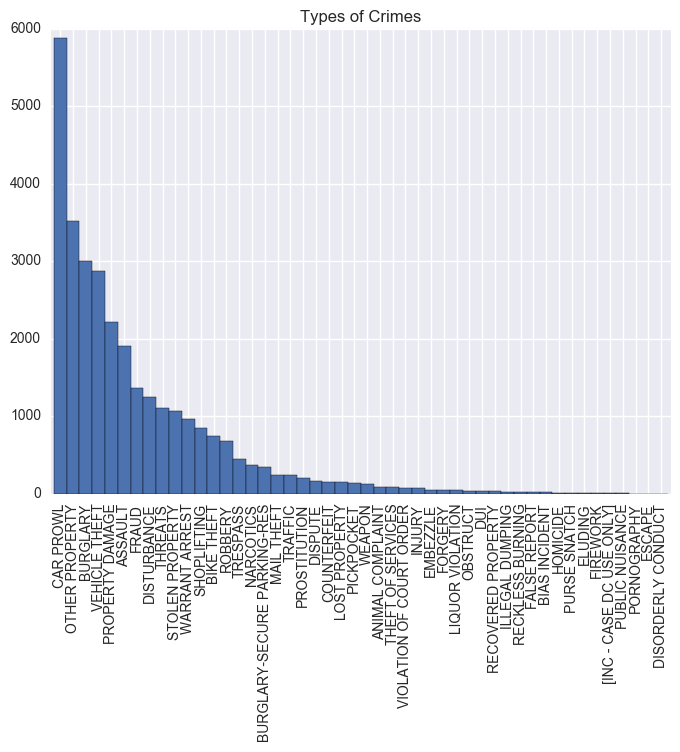

In [4]:
# Constructs Frequency Distribution
crimes = set(seattleDF['description'])
freqs = [sum(seattleDF['description'] == c) for c in crimes]
descriptionFreqs = pd.Series(data=freqs,index=crimes)
descriptionFreqs.sort(ascending=False)

# Prints Top 10
print('10 most frequent crimes:')
print('--------------------------')
for i in range(10):
    print('%*s | %i' % (15, descriptionFreqs.index[i], descriptionFreqs[i]))
    
# Plots Pareto Chart
plt.figure(figsize=(8,6))
descriptionFreqs.plot(kind='bar', title='Types of Crimes', width=1)

Now let's answer: ***When* are crimes most frequent?** An answer to this question could help with staffing for patrol officers.

10 most frequent times:
-------------------------
    Sunday |   0 | 350
    Friday |  12 | 324
  Thursday |  12 | 310
    Friday |   0 | 303
    Friday |  22 | 303
    Monday |  21 | 297
    Friday |  23 | 297
   Tuesday |   0 | 290
    Sunday |  21 | 287
  Saturday |   0 | 282


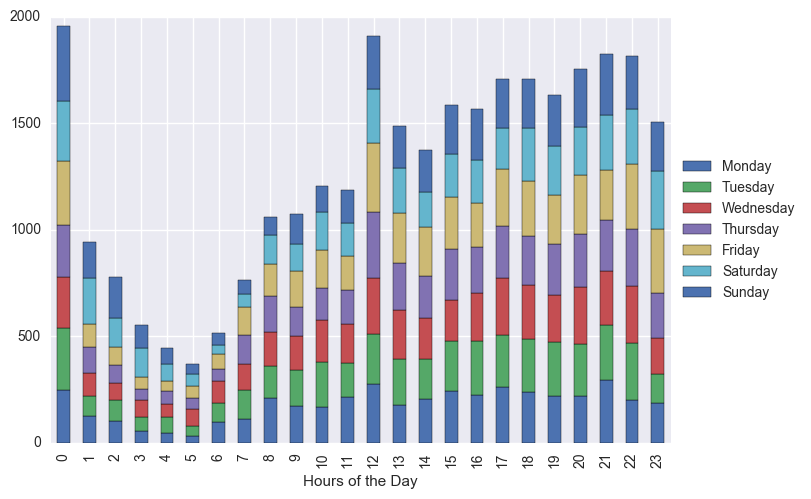

In [5]:
# Builds a two-dimensional frequency distribution
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hours = range(0,24)
dailyFreqs = pd.DataFrame()
for day in range(len(days)):
    freqs = [sum(seattleDF.loc[seattleDF['dayofweek'] == day,'hour'] == hour) for hour in hours]
    dailyFreqs[days[day]] = pd.Series(freqs)

# Prints 10 most frequent times
dailyFreqsArray = dailyFreqs.copy().as_matrix()
print('10 most frequent times:')
print('-------------------------')
for i in range(10):
    idx = np.argmax(dailyFreqsArray)
    row = idx//7
    col = idx%7
    day = dailyFreqs.columns[col]
    hour = dailyFreqs.index[row]
    freq = dailyFreqs.iloc[row, col]
    print('%*s | %*d | %d' % (10, day, 3, hour, freq))
    dailyFreqsArray[row, col] = 0
    
# Plots a stacked bar chart from frequency distribution
dailyFreqs.plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hours of the Day')

Finally, we want to know ***Where* are crimes most frequent?** This will help the police determine if certain zones need more/less attention; ideally, attention should be proportional to the amount of crime in each zone.

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


10 most frequent zones:
--------------------------
   E2 | 1041
   M3 | 911
   M1 | 806
   K2 | 795
   M2 | 787
   B2 | 776
   B3 | 767
   U2 | 754
   N3 | 754
   D1 | 736


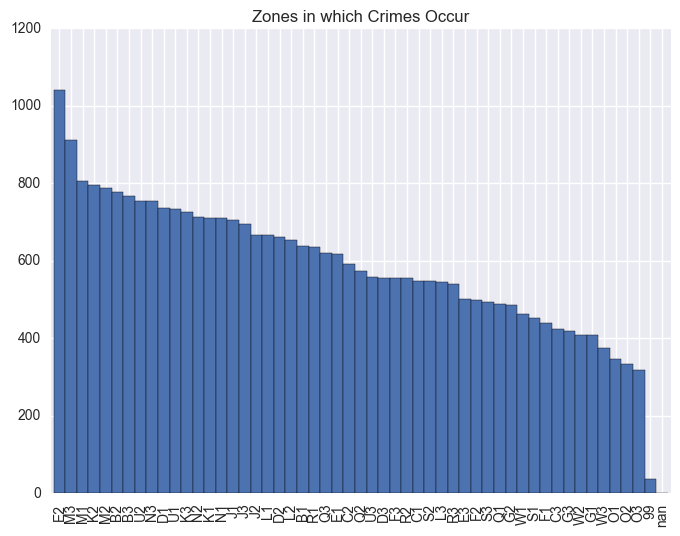

In [6]:
# Constructs Frequency Distribution
zones = set(seattleDF['zone'])
freqs = [sum(seattleDF['zone'] == z) for z in zones]
zoneFreqs = pd.Series(data=freqs, index=zones)
zoneFreqs.sort(ascending=False)

# Prints Top 10
print('10 most frequent zones:')
print('--------------------------')
for i in range(10):
    print('%*s | %i' % (5, zoneFreqs.index[i], zoneFreqs[i]))
    
# Plots Pareto Chart
plt.figure(figsize=(8,6))
zoneFreqs.plot(kind='bar', title='Zones in which Crimes Occur', width=1)

Because of the large number of zones, perhaps it will be more meaningful to consider the districts.

5 most frequent districts:
--------------------------
  M | 2504
  K | 2230
  B | 2181
  N | 2175
  E | 2157


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


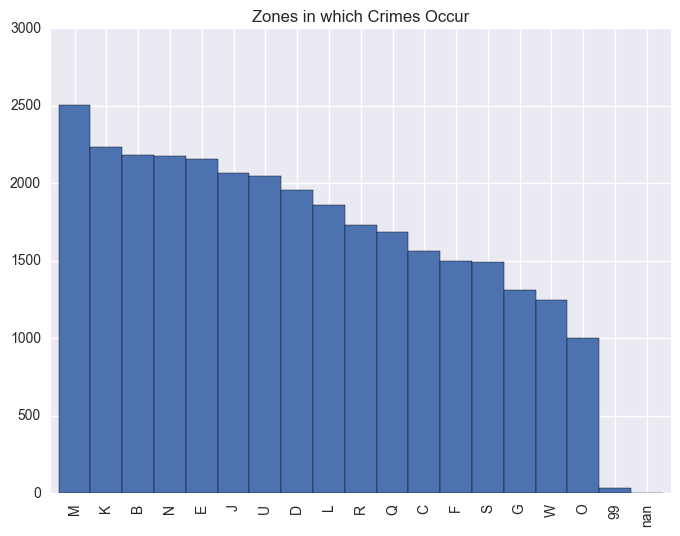

In [7]:
# Constructs Frequency Distribution
districts = set(seattleDF['district'])
freqs = [sum(seattleDF['district'] == d) for d in districts]
districtFreqs = pd.Series(data=freqs, index=districts)
districtFreqs.sort(ascending=False)

# Prints Top 10
print('5 most frequent districts:')
print('--------------------------')
for i in range(5):
    print('%*s | %i' % (3, districtFreqs.index[i], districtFreqs[i]))
    
# Plots Pareto Chart
plt.figure(figsize=(8,6))
districtFreqs.plot(kind='bar', title='Zones in which Crimes Occur', width=1)

## Step 3: Finding Better Districts

Our goal here is to use K-means clustering algorithm to create new districts to most efficiently combat Seattle crime.

Let's first get an idea of what the current districts are.

In [8]:
from sklearn.cluster import KMeans
from mpl_toolkits.basemap import Basemap

In [9]:
X = seattleDF[['lat','lon']].as_matrix()
kmeans = KMeans(n_clusters=len(districts), n_init=50, n_jobs=-1).fit(X)
seattleDF['cluster_ctr'] = pd.Series(kmeans.predict(X), index=seattleDF.index)

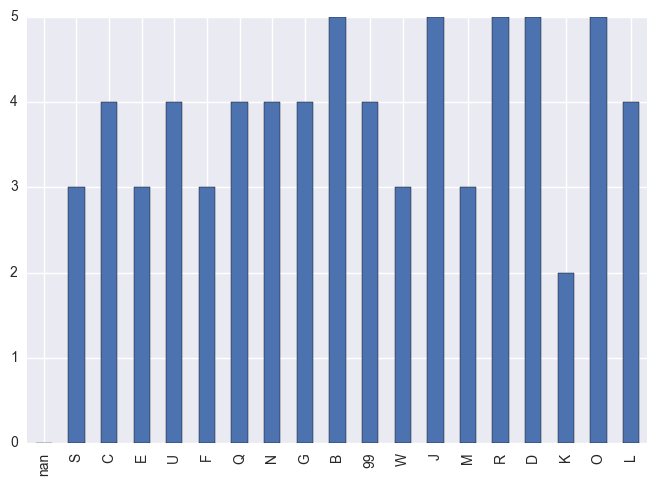

In [11]:
clusters = []
for district in districts:
    clusters.append(len(set(seattleDF.loc[seattleDF['district'] == district, 'cluster_ctr'])))
districtsClusterFreq = pd.Series(data=clusters, index=districts)
districtsClusterFreq.plot(kind='bar')

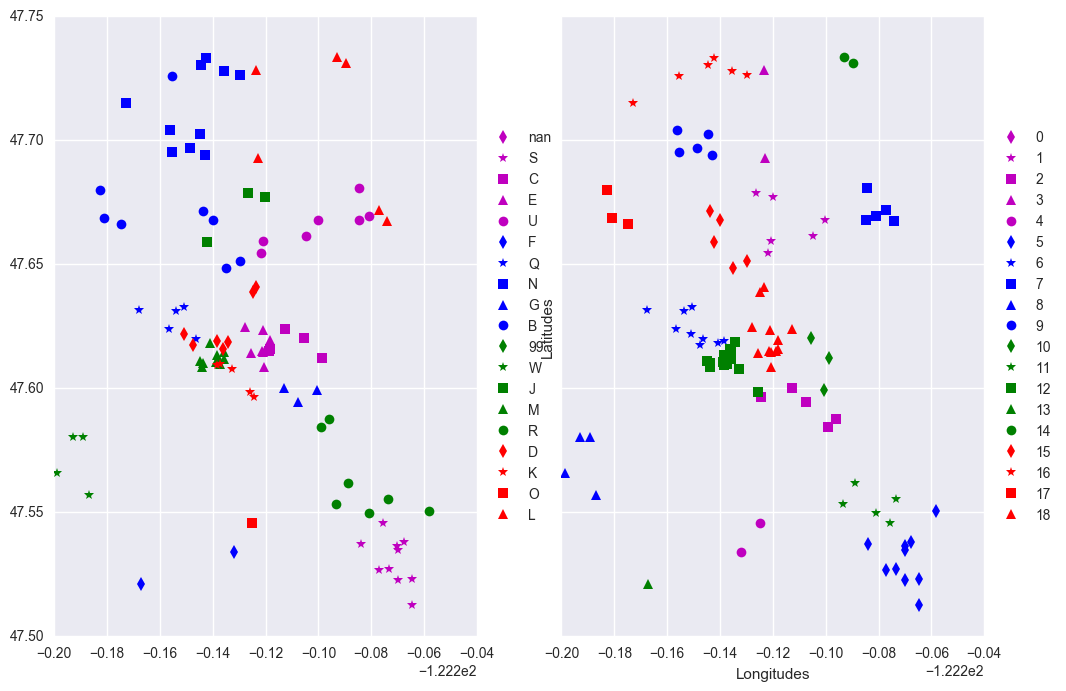

In [12]:
sample = seattleDF.sample(n=100)
blips = [color+shape for color in 'rgbm' for shape in 'o^s*d']
fig, (dplot, cplot) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(12,8))
plt.xlabel('Longitudes')
plt.ylabel('Latitudes')
for d in districts:
    X = sample.loc[sample['district'] == d, 'lon']
    Y = sample.loc[sample['district'] == d, 'lat']
    dplot.plot(X, Y, blips.pop(), label=d)
    dplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))

blips = [color+shape for color in 'rgbm' for shape in 'o^s*d']
for c in range(len(districts)):
    X = sample.loc[sample['cluster_ctr'] == c, 'lon']
    Y = sample.loc[sample['cluster_ctr'] == c, 'lat']
    cplot.plot(X, Y, blips.pop(), label=c)
    cplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))

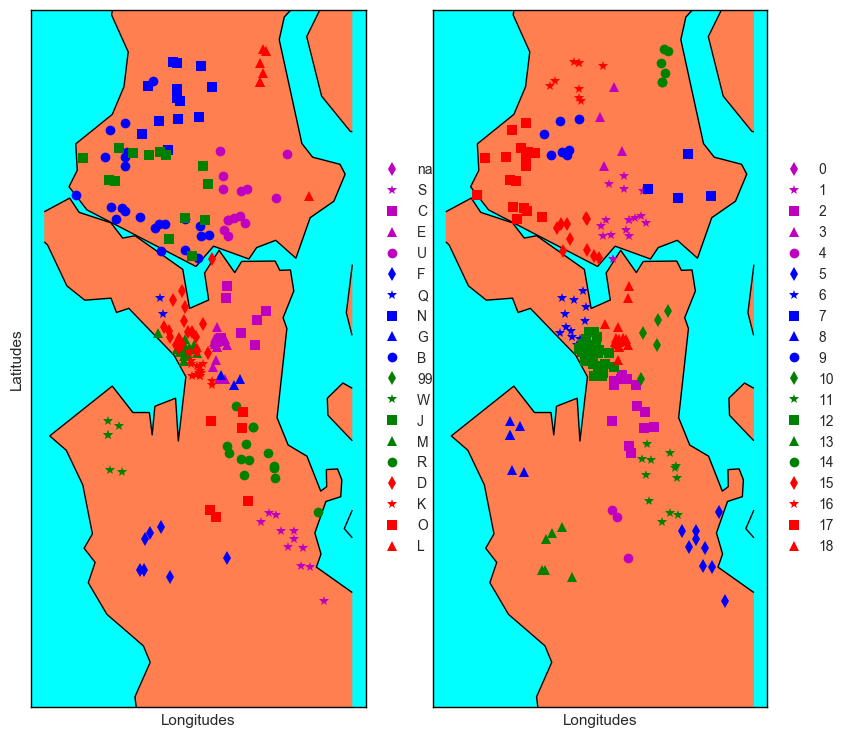

In [13]:
llcrnrlon = np.min(seattleDF['lon'])-0.0001
llcrnrlat = np.min(seattleDF['lat'])-0.0001
urcrnrlon = np.max(seattleDF['lon'])+0.0001
urcrnrlat = np.max(seattleDF['lat'])+0.0001

sample = seattleDF.sample(n=200)

fig, (dplot, cplot) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(9.5,9))

m = Basemap(projection='merc', resolution='h', 
            llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
            urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat, ax=dplot)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='coral', lake_color='aqua')
blips = [color+shape for color in 'rgbm' for shape in 'o^s*d']
dplot.set_xlabel('Longitudes')
dplot.set_ylabel('Latitudes')
for d in districts:
    X = sample.loc[sample['district'] == d, 'lon'].copy().as_matrix()
    Y = sample.loc[sample['district'] == d, 'lat'].copy().as_matrix()
    X, Y = m(X, Y)
    m.plot(X, Y, blips.pop(), label=d)
    dplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))

m = Basemap(projection='merc', resolution='h', 
            llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
            urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat, ax=cplot)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='coral', lake_color='aqua')
blips = [color+shape for color in 'rgbm' for shape in 'o^s*d']
cplot.set_xlabel('Longitudes')
for c in range(len(districts)):
    X = sample.loc[sample['cluster_ctr'] == c, 'lon'].copy().as_matrix()
    Y = sample.loc[sample['cluster_ctr'] == c, 'lat'].copy().as_matrix()
    X, Y = m(X, Y)
    m.plot(X, Y, blips.pop(), label=c)
    cplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
plt.show()

How should we evaluate the accuracy of our crime clusters as the new districts versus the old layout of districts? We will take the distance between the crimes and the crime cluster centers as a cost measure for the new districts. For the old districts, we will use the distance between each crime and the average location of all crimes in that district.

In [14]:
# Gets average lat/lon for each district and adds it to record for crime in that district
for dist in districts:
    seattleDF['district_avg_lat'] = seattleDF.loc[seattleDF['district'] == dist, 'lat'].mean()
    seattleDF['district_avg_lon'] = seattleDF.loc[seattleDF['district'] == dist, 'lon'].mean()

# Gets cluster center lat/lon for each crime and adds it to record for that crime
cluster_ctrs = kmeans.cluster_centers_[seattleDF['cluster_ctr'].as_matrix()]
seattleDF['cluster_ctr_lat'] = pd.Series(cluster_ctrs[:, 0], index=seattleDF.index)
seattleDF['cluster_ctr_lon'] = pd.Series(cluster_ctrs[:, 1], index=seattleDF.index)

# Calculate distance between each crime and avg lat/lon for old district 
# Note: Euclidean distance = sqrt((lat0-lat1)^2 + (lon0-lon1)^2)
district_avgs = seattleDF[['district_avg_lat', 'district_avg_lon']].as_matrix()
crime_lat_lons = seattleDF[['lat', 'lon']].as_matrix()
seattleDF['district_distance'] = pd.Series(np.sqrt(np.sum(np.square(district_avgs - crime_lat_lons), axis=1)),
                                          index=seattleDF.index)

# Caldulate distance between each crim and the cluster center (new district center)
cluster_ctrs = seattleDF[['cluster_ctr_lat', 'cluster_ctr_lon']].as_matrix()
seattleDF['cluster_distance'] = pd.Series(np.sqrt(np.sum(np.square(cluster_ctrs - crime_lat_lons), axis=1)),
                                          index=seattleDF.index)

seattleDF[['district_distance', 'cluster_distance']].describe()

,district_distance,cluster_distance
count,30729.000000,30729.000000
mean,0.100139,0.010948
std,0.047593,0.006099
min,0.001645,0.000095
25%,0.065655,0.006148
50%,0.100985,0.009889
75%,0.115601,0.014863
max,0.248561,0.070320


The cost of the new districts (mean cluster_distance) is smaller than the cost of the old districs (mean district_distance) by nearly a factor of 10! Our new districts according to the clusters is a significant improvement! The variance of crimes in the new district is also smaller than in the old districts.

Let's try to wrap our head around these numbers. 1 latitudinal/longitudinal degree is approximately equal to 69 miles. Then in the old districts, each crime is about 1/10 of a degree from the average crime location in that district. That's about 6.9 miles from the center! In the new districts, each crime is about 1/100 of a degree from the cluster center. That's about 0.69 miles --- less than a mile away! The can only imagine that the new districts would make a large difference in the daily distance travelled by police officers.

# Conclusion

In this look at Seattle crime, we considered answers to the questions what, when, and where are the crimes? We then used a KMeans clustering algorithm to create new districts that most accurately fits the concentration of crime. We found that the new districts made significantly decreased the distance of crimes from it's district's center (by about a factor of 10).

Some ways to potentially improve our analysis:

* We answered what/when/where about the crimes, but it would be interesting to combine these questions. For example, what crimes are most frequent in the evening vs. what crimes are most frequent in the morning?
* KMeans is clustering using euclidean distance. Distance between lat/lon points is not exactly Euclidean. Implementing KMeans with a great-circle distance between two points might do better.
* Appropriate crime weights. Perhaps the areas with violent crimes should have a higher police presence than those with less violent crimes. We could implement a crime weight for the severity of certain types of crimes.
* Time series analysis. Has a particular type of crime or location seen an increase in occurrence over time?
* Most efficient number of clusters?
* Evaluating the accuracy of the new districts used a euclidean distance. This may not be practical, since Euclidean distance gives a distance in the way a bird flies rather than the distance it takes a patrol officer to drive to the crime scene. We could find driving distance/time by connecting to the Google Maps API. This may give us a better measure of accuracy.